In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
import pandas as pd
import os
path='/content/drive/MyDrive/CVSfileHecktor'
pathf=pd.read_csv('/content/drive/MyDrive/CVSfileHecktor/Radiomics_features_hecktor2021.csv')
radiofeature=pathf


In [4]:
radiofeature

,PatientID,Elongation,Flatness,LeastAxisLength,MajorAxisLength,Maximum2DDiameterColum,Maximum2DDiameterRow,Maximum2DDiameterSlice,Maximum3DDiameter,MeshVolume,MinorAxisLength,Sphericity,SurfaceArea,SurfaceVolumeRatio,VoxelVolume,firstorder_10Percentile,firstorder_90Percentile,firstorder_Energy,firstorder_Entropy,InterquartileRange,firstorder_InterquartileRange,firstorder_Kurtosis,firstorder_Maximum,firstorder_MeanAbsoluteDeviation,firstorder_Mean,firstorder_Median,firstorder_Minimum,firstorder_Range,firstorder_RobustMeanAbsoluteDeviation,firstorder_RootMeanSquared,firstorder_Skewness,firstorder_TotalEnergy,firstorder_Uniformity,firstorder_Variance,glcm_Autocorrelation,glcm_ClusterProminence,glcm_ClusterShade,glcm_ClusterTendency,glcm_Contrast,glcm_Correlation,...,gldm_SmallDependenceLowGrayLevelEmphasi,glrlm_GrayLevelNonUniformity,glrlm_GrayLevelNonUniformityNormalized,glrlm_GrayLevelVariance,glrlm_HighGrayLevelRunEmphasis,glrlm_LongRunEmphasis,glrlm_LongRunHighGrayLevelEmphasi,glrlm_LongRunLowGrayLevelEmphasis,glrlm_LowGrayLevelRunEmphasis,glrlm_RunEntropy,glrlm_RunLengthNonUniformity,glrlm_RunLengthNonUniformityNormalized,glrlm_RunPercentage,glrlm_RunVariance,glrlm_ShortRunEmphasis,glrlm_ShortRunHighGrayLevelEmphasis,glrlm_ShortRunLowGrayLevelEmphasis,glszm_GrayLevelNonUniformity,glszm_GrayLevelNonUniformityNormalized,glszm_GrayLevelVariance,glszm_HighGrayLevelZoneEmphasis,glszm_LargeAreaEmphasis,glszm_LargeAreaHighGrayLevelEmphasis,glszm_LargeAreaLowGrayLevelEmphasis,glszm_LowGrayLevelZoneEmphasis,glszm_SizeZoneNonUniformity,glszm_SizeZoneNonUniformityNormalized,glszm_SmallAreaEmphasis,glszm_SmallAreaHighGrayLevelEmphasis,glszm_SmallAreaLowGrayLevelEmphasis,glszm_ZoneEntropy,glszm_ZonePercentage,glszm_ZoneVariance,ngtdm_Busyness,ngtdm_Coarseness,ngtdm_Complexity,ngtdm_Contrast,ngtdm_Strength,Progression,Progression free survival
0,CHGJ007,0.850691,0.719053,35.365014,49.182734,56.293872,59.236813,49.729267,61.212744,48102.875000,41.839310,0.648745,9859.555466,0.204968,48180.0,18.037995,61.479379,1.115449e+08,1.808980,17.284489,17.284489,21.406229,222.244781,15.519158,40.843689,44.484383,-396.458557,618.703339,7.617330,48.116206,-2.660773,1.115449e+08,0.389656,646.962410,330.023191,1.479838e+02,-12.277906,3.481183,0.598885,0.705288,...,0.000077,5828.700797,0.289549,1.874893,326.068860,12.356960,4080.417016,0.037804,0.003264,4.426718,6243.447066,0.304740,0.415525,6.075458,0.557688,179.169162,0.001912,54.791045,0.102222,10.889616,260.423507,1.640119e+06,5.433728e+08,4961.405631,0.006895,126.981343,0.236905,0.498348,115.894019,0.003521,6.206172,0.011125,1.632039e+06,6.851898,0.000198,100.601263,0.001518,0.188724,1,310
1,CHGJ008,0.691639,0.686041,17.612623,25.672845,30.413813,28.792360,22.472205,31.638584,5291.583333,17.756346,0.744359,1972.842025,0.372826,5320.0,29.296611,64.273505,1.320701e+07,1.507097,17.613300,17.613300,6.782951,145.559540,11.604022,47.188469,47.752563,-63.102901,208.662441,7.375090,49.824908,-0.363823,1.320701e+07,0.417654,255.769796,29.619700,1.090491e+01,-0.315762,1.534479,0.342274,0.634260,...,0.000615,788.840453,0.371803,0.694000,29.082617,11.694873,349.630234,0.413502,0.039354,4.088482,579.937217,0.265253,0.397715,4.579681,0.503815,14.376104,0.021371,8.377778,0.186173,3.137778,26.822222,2.580176e+05,7.536459e+06,9127.911422,0.083423,5.844444,0.129877,0.245172,6.657075,0.022222,5.013858,0.008459,2.440411e+05,8.167909,0.001714,10.934231,0.004034,0.085904,0,2037
2,CHGJ010,0.971957,0.924111,14.285181,15.458301,19.209373,19.416488,17.720045,19.442222,2284.583333,15.024809,0.811556,1033.642425,0.452442,2303.0,41.853915,66.368690,7.246529e+06,1.015042,11.951128,11.951128,18.286250,80.866188,8.574871,54.516756,56.916710,-61.508060,142.374249,4.969688,56.094210,-2.921513,7.246529e+06,0.611189,174.483674,33.174361,1.693691e+01,-3.115414,1.054310,0.314817,0.540617,...,0.001000,335.072066,0.422144,0.598853,30.075600,17.174194,600.235929,0.504346,0.038922,3.741196,208.855065,0.256349,0.343398,7.730747,0.508042,13.91

In [5]:
radiofeature.rename(columns={'Progression free survival':'target'}, inplace=True)

In [6]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

features_use=[c for c in radiofeature.columns if c not in ('PatientID','Progression','target')]
#self.useful_features = [c for c in self.df.columns if c not in ("participant_id", "target", "kfold")]

dataset_X = radiofeature[features_use]
scaler = MinMaxScaler(feature_range=(0,1))
X_ = scaler.fit_transform(dataset_X)
X_train = pd.DataFrame(X_, columns=dataset_X.columns)

# Function to list features that are correlated
# Adds the first of the correlated pair only (not both)
def correlatedFeatures(dataset, threshold):
    correlated_columns = set()
    correlations = dataset.corr()
    for i in range(len(correlations)):
        for j in range(i):
            if abs(correlations.iloc[i,j]) > threshold:
                correlated_columns.add(correlations.columns[i])
    return correlated_columns



# Split into train (2/3) and test (1/3) sets
# test_size = 0.20
# seed = 7
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# Feature selection
# Remove low variance features
# Identify some low variance features, those with variance 
# less than 0.1 and remove them.

# # Check the shape before we remove anything
# X_test.shape
X_train.var()
sel = VarianceThreshold(threshold=(0.01))
sel.fit(X_train)

selected_features = list(X_train.columns[sel.get_support()])
print("Feature selection", sel.get_support())
print("Selected features:", selected_features)
print("Removed features:", list(X_train.columns[~sel.get_support()]))

# Transform (remove low variance features)
X_train = sel.transform(X_train)
#X_test = sel.transform(X_test)

# Turn back into a dataframe
X_train = pd.DataFrame(X_train, columns=selected_features)
#X_test = pd.DataFrame(X_test, columns=selected_features)

# Confirm the new shape
print(X_train.shape)

# Correlated features
# Remove highly correlated features

# Get a set of correlated features, based on threshold correlation of 0.85
cf = correlatedFeatures(X_train, 0.85)
cf

# Remove the correlated features
X_train = X_train.drop(cf, axis=1)
#X_test = X_test.drop(cf, axis=1)

# Confirm the new shape
print(X_train.shape)

Feature selection [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True False  True  True  True  True  True  True  True
 False  True  True  True  True  True False  True False  True False False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True False  True  True  True  True  True  True  True  True False
  True False  True  True False  True  True  True False  True  True  True
  True  True  True False  True False  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True False False False]
Selected features: ['Elongation', 'Flatness', 'LeastAxisLength', 'MajorAxisLength', 'Maximum2DDiameterColum', 'Maximum2DDiameterRow', 'Maximum2DDiameterSlice', 'Maximum3DDiameter', 'MeshVolume', 'MinorAxisLength', 'Sphericity', 'SurfaceArea', 'SurfaceVolumeRatio', 'VoxelVolume', 'firstorder_90Percentile', 'firstorder_Entro

In [7]:
ytrain=radiofeature[['target', 'Progression']]
radiof_df = pd.merge(X_train,ytrain, left_index=True, right_index=True)
radiof_df.insert(0,'PatientID',radiofeature['PatientID'])

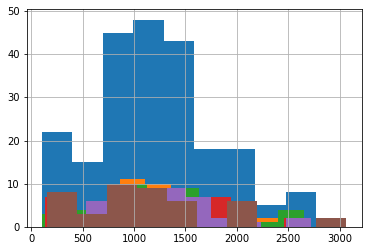

In [8]:
import numpy as np
import pandas as pd
import os
from sklearn import model_selection
#path='/content/drive/MyDrive/CVSfileHecktor'
#pathc=os.path.join(path,'clinical_hecktor1.csv')
df_train = radiof_df
df_train["kfold"] = -1
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df_train)):
    df_train.loc[valid_indicies, "kfold"] = fold
df_train.kfold.count()
#df_train.loc['Progression free survival'] 
#df_train.rename(columns={'Progression free survival':'target'}, inplace=True)
df_train.target.hist()
df_train.kfold.value_counts()
df_train[df_train.kfold==0].target.hist()
df_train[df_train.kfold==1].target.hist()
df_train[df_train.kfold==2].target.hist()
df_train[df_train.kfold==3].target.hist()
df_train[df_train.kfold==4].target.hist()

In [9]:
!pip install lifelines

     |████████████████████████████████| 348 kB 5.4 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=a38c5a4f2ea6142f7395391eef650b78beabaa476654be2c08f23665542c5bd5
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [11]:
df_train

,PatientID,Elongation,Flatness,LeastAxisLength,MajorAxisLength,Sphericity,SurfaceVolumeRatio,firstorder_90Percentile,firstorder_Entropy,firstorder_Kurtosis,firstorder_Maximum,firstorder_Mean,firstorder_Minimum,firstorder_Skewness,glcm_Correlation,glcm_Idmn,glcm_Imc1,gldm_DependenceNonUniformity,gldm_DependenceNonUniformityNormalized,gldm_DependenceVariance,gldm_LargeDependenceHighGrayLevelEmphasis,gldm_LargeDependenceLowGrayLevelEmphasis,gldm_SmallDependenceLowGrayLevelEmphasi,glrlm_LongRunEmphasis,glrlm_RunEntropy,glszm_GrayLevelNonUniformityNormalized,glszm_LargeAreaLowGrayLevelEmphasis,glszm_SizeZoneNonUniformityNormalized,glszm_ZoneEntropy,ngtdm_Busyness,ngtdm_Coarseness,target,Progression,kfold
0,CHGJ007,0.806420,0.696127,0.575574,0.541071,0.559819,0.092490,0.137344,0.349069,0.056111,0.052296,0.647785,0.625587,0.500660,0.761927,0.961589,0.352859,0.129823,0.022047,0.446009,0.180843,0.016751,0.007563,0.114200,0.623249,0.239327,0.058289,0.290057,0.670212,0.165536,0.008647,310,1,2
1,CHGJ008,0.552523,0.647205,0.216527,0.201733,0.774392,0.320693,0.152573,0.258596,0.010444,0.028200,0.696876,0.932581,0.629545,0.647279,0.807051,0.361166,0.013329,0.032966,0.384028,0.014499,0.208074,0.123873,0.106843,0.437192,0.490556,0.107242,0.053742,0.406075,0.197535,0.093407,2037,0,4
2,CHGJ010,1.000000,1.000000,0.149228,0.054297,0.925195,0.428930,0.163992,0.111130,0.046367,0.007872,0.753576,0.934050,0.486029,0.496129,0.713977,0.587873,0.007219,0.117581,0.619465,0.021611,0.205540,0.207011,0.167729,0.246157,0.588046,0.043180,0.142639,0.163372,0.082162,0.257401,1917,0,2
3,CHGJ013,0.465179,0.316041,0.129838,0.247011,0.809194,0.321076,0.117151,0.247294,0.027704,0.021097,0.679775,0.890350,0.590433,0.460902,0.788031,0.581640,0.012857,0.040156,0.321329,0.022474,0.096640,0.126055,0.087311,0.298929,0.468343,0.064641,0.183732,0.299812,0.145332,0.079284,1377,0,3
4,CHGJ015,0.762084,0.607350,0.119884,0.112218,0.822685,0.429129,0.139790,0.214582,0.034405,0.011361,0.689746,0.874332,0.566108,0.280658,0.792890,0.738289,0.005613,0.025276,0.413201,0.030101,0.071596,0.127884,0.080026,0.183355,0.826566,0.020361,0.084653,0.247297,0.112317,0.144655,1072,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,CHUP019,0.261898,0.075835,0.132336,0.477270,0.302776,0.473152,0.550260,0.772068,0.047927,0.095402,0.822176,0.213807,0.577672,0.698698,0.924382,0.563051,0.029727,0.181158,0.006455,0.167221,0.000274,0.039209,0.001924,0.584684,0.104522,0.000063,0.498520,0.739094,0.005410,0.089002,161,1,2
220,CHUP020,0.823544,0.723372,1.000000,0.934110,0.491539,0.000000,0.170863,0.560681,0.174339,0.186875,0.533182,0.017045,0.295822,0.955489,0.957612,0.676650,0.663768,0.085089,0.152587,0.488098,0.001119,0.018335,0.018696,0.513282,0.087034,0.006211,0.597355,0.897184,0.096058,0.000000,394,1,4
221,CHUP021,0.328192,0.220681,0.156070,0.361219,0.588664,0.334362,0.343137,0.638307,0.164733,0.068050,0.692254,0.099369,0.352310,0.650552,0.926079,0.618502,0.024527,0.101803,0.131581,0.325118,0.000472,0.038490,0.009731,0.511290,0.117482,0.000170,0.538460,0.723106,0.004792,0.069645,874,0,0
222,CHUP022,0.705752,0.329182,0.358022,0.584612,0.064932,0.397408,0.656968,0.984019,0.120153,1.000000,0.902713,0.041992,0.883306,0.959866,0.962719,0.413468,0.081694,0.161093,0.064316,0.239589,0.000000,0.036683,0.000934,1.000000,0.000000,0.000059,0.797727,1.000000,0.002219,0.030756,2401,0,1


[09:01:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0 565.3451771977603
[09:01:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 664.1553695643273
[09:01:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2 654.5107780503536
[09:01:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3 570.4416534712459
Concordance index_XGB_fold1: 0.5272727272727272
Concordance index_XGB_fold2: 0.509090909090909
Concordance index_XGB_fold3: 0.5404040404040404
Concordance index_XGB_fold4: 0.39979757085020245


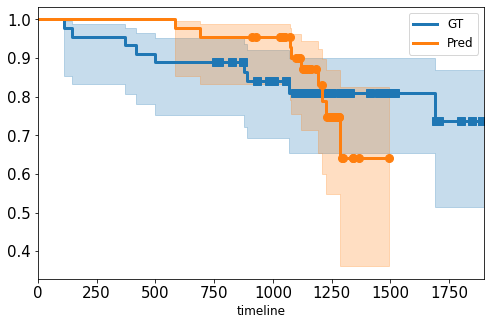

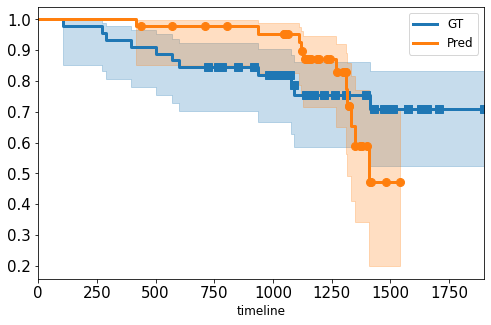

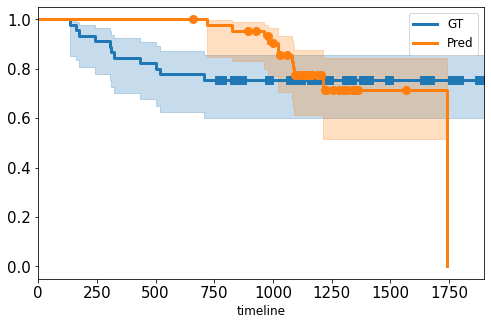

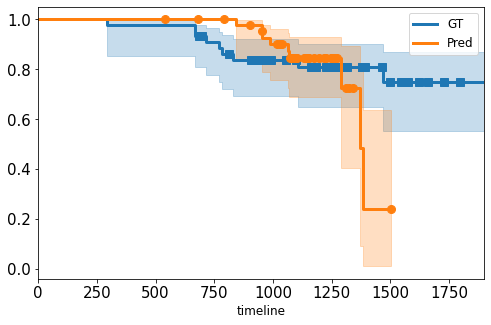

In [12]:
#XGBRegressor model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
#path='/content/drive/MyDrive/CVSfileHecktor'
#patht=os.path.join(path,'topfeature_fold.csv')
#df = pd.read_csv(patht)
#df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
# #sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# useful_features = [c for c in df.columns if c not in ("participant_id", "target", "kfold")]
# #object_cols = [col for col in useful_features if 'cat' in col]
# #df_test = df_test[useful_features]
# xgb='ggg'
#df = pd.read_csv(patht)
df=df_train
useful_features = [c for c in df.columns if c not in ("PatientID", "target","Progression", "kfold")]
final_predictions = []
final_true = []
y_eventf=[]
for fold in range(4):
  xtrain =  df[df.kfold != fold].reset_index(drop=True)
  xvalid = df[df.kfold == fold].reset_index(drop=True)
  ytrain = xtrain.target
  yvalid = xvalid.target
  y_event=xvalid.Progression
  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]
  min_max_scaler = preprocessing.MinMaxScaler()
  xtrain= min_max_scaler.fit_transform(xtrain)
  xvalid= min_max_scaler.transform(xvalid)
  model=XGBRegressor(n_estimators=500, learning_rate=0.03, n_jobs=4)
  model.fit(xtrain, ytrain, early_stopping_rounds=5, eval_set=[(xvalid, yvalid)],verbose=False)
  #model.fit(xtrain, ytrain)
  preds_valid = model.predict(xvalid)
  #test_preds = model.predict(xtest)
  final_predictions.append(preds_valid)
  final_true.append(yvalid)
  y_eventf.append(y_event)
  print(fold, mean_squared_error(yvalid, preds_valid, squared=False))

# predicted survival days for each fold
pred=final_predictions[0]
pred1=final_predictions[1]
pred2=final_predictions[2]
pred3=final_predictions[3]
# true survival days for each fold
true=(final_true)[0]
true1=(final_true)[1]
true2=(final_true)[2]
true3=(final_true)[3]
# event occured for each fold
event=np.array(y_eventf)[0]
event1=np.array(y_eventf)[1]
event2=np.array(y_eventf)[2]
event3=np.array(y_eventf)[3]
## compute c index for each fold
from lifelines.utils import concordance_index
print(f'Concordance index_XGB_fold1: {concordance_index(true, pred)}')
print(f'Concordance index_XGB_fold2: {concordance_index(true1, pred1)}')
print(f'Concordance index_XGB_fold3: {concordance_index(true2, pred2)}')
print(f'Concordance index_XGB_fold4: {concordance_index(true3, pred3)}')

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true, event, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred, event, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true1, event1, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred1, event1, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true2, event2, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred2, event2, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true3, event3, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred3, event3, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

0 590.8003635886897
1 653.7433111150675
2 706.5115498644556
3 613.105403558407
Concordance index_XGB_fold1: 0.5173501577287066
Concordance index_XGB_fold2: 0.581151832460733
Concordance index_XGB_fold3: 0.6410256410256411
Concordance index_XGB_fold4: 0.5316455696202531


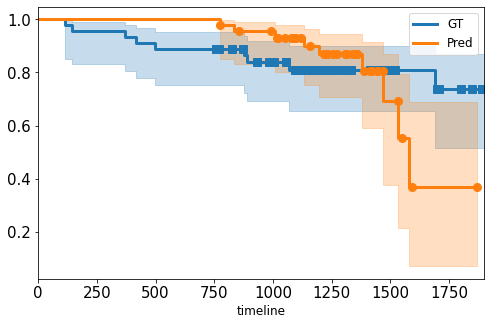

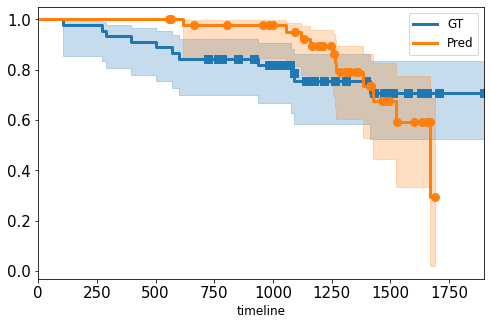

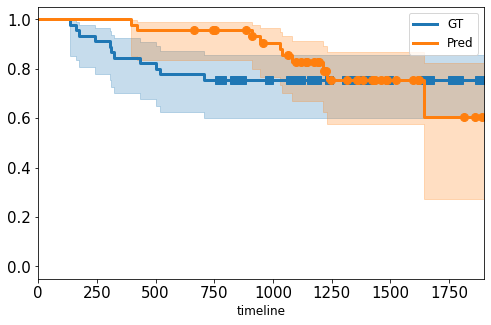

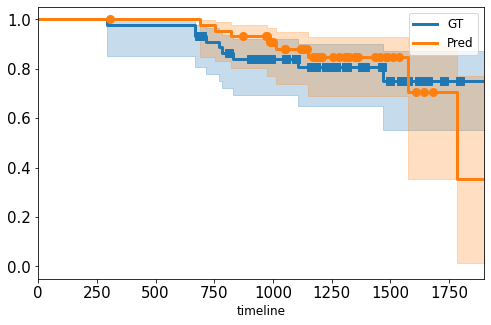

In [14]:
#GradientBoostingRegressor
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
#path='/content/drive/MyDrive/CVSfileHecktor'
#patht=os.path.join(path,'topfeature_fold.csv')
#df = pd.read_csv(patht)
#df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
# #sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# useful_features = [c for c in df.columns if c not in ("participant_id", "target", "kfold")]
# #object_cols = [col for col in useful_features if 'cat' in col]
# #df_test = df_test[useful_features]
# xgb='ggg'
#df = pd.read_csv(patht)
df=df_train
useful_features = [c for c in df.columns if c not in ("PatientID", "target","Progression", "kfold")]
final_predictions = []
final_true = []
y_eventf=[]
for fold in range(4):
  xtrain =  df[df.kfold != fold].reset_index(drop=True)
  xvalid = df[df.kfold == fold].reset_index(drop=True)
  ytrain = xtrain.target
  yvalid = xvalid.target
  y_event=xvalid.Progression
  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]
  min_max_scaler = preprocessing.MinMaxScaler()
  xtrain= min_max_scaler.fit_transform(xtrain)
  xvalid= min_max_scaler.transform(xvalid)
  model=GradientBoostingRegressor(n_estimators=700,random_state=42)
  model.fit(xtrain, ytrain)
  #model.fit(xtrain, ytrain)
  preds_valid = model.predict(xvalid)
  #test_preds = model.predict(xtest)
  final_predictions.append(preds_valid)
  final_true.append(yvalid)
  y_eventf.append(y_event)
  print(fold, mean_squared_error(yvalid, preds_valid, squared=False))

# predicted survival days for each fold
pred=final_predictions[0]
pred1=final_predictions[1]
pred2=final_predictions[2]
pred3=final_predictions[3]
# true survival days for each fold
true=(final_true)[0]
true1=(final_true)[1]
true2=(final_true)[2]
true3=(final_true)[3]
# event occured for each fold
event=np.array(y_eventf)[0]
event1=np.array(y_eventf)[1]
event2=np.array(y_eventf)[2]
event3=np.array(y_eventf)[3]
## compute c index for each fold
from lifelines.utils import concordance_index
print(f'Concordance index_XGB_fold1: {concordance_index(true, pred,event)}')
print(f'Concordance index_XGB_fold2: {concordance_index(true1, pred1,event1)}')
print(f'Concordance index_XGB_fold3: {concordance_index(true2, pred2,event2)}')
print(f'Concordance index_XGB_fold4: {concordance_index(true3, pred3,event3)}')

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true, event, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred, event, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true1, event1, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred1, event1, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true2, event2, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred2, event2, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true3, event3, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred3, event3, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

0 573.6071597912717
1 637.5435701350491
2 650.1542369691822
3 551.2940029361224
Concordance index_XGB_fold1: 0.6309148264984227
Concordance index_XGB_fold2: 0.5575916230366492
Concordance index_XGB_fold3: 0.6946386946386947
Concordance index_XGB_fold4: 0.46835443037974683


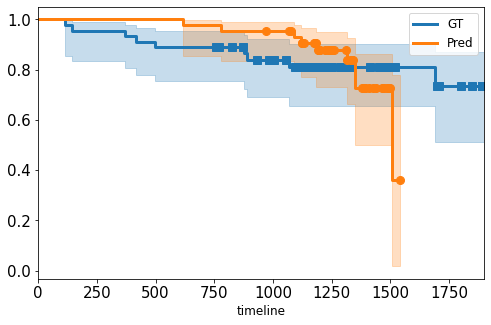

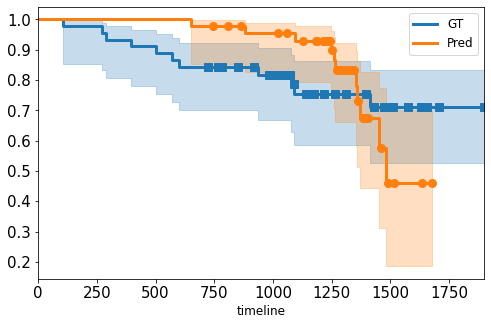

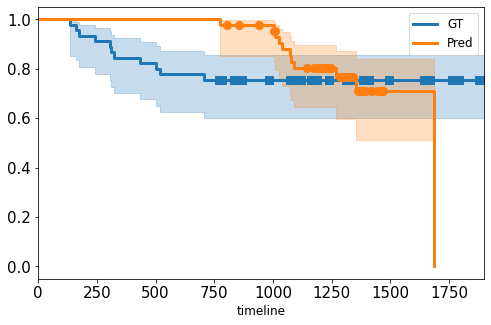

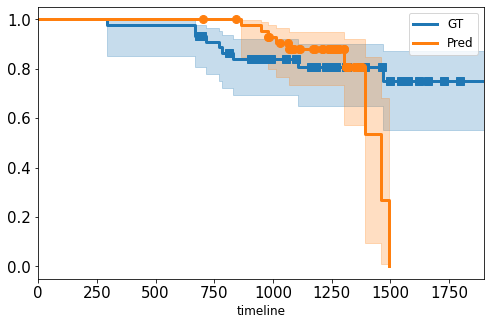

In [15]:
#RandomForestRegressor
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
#path='/content/drive/MyDrive/CVSfileHecktor'
#patht=os.path.join(path,'topfeature_fold.csv')
#df = pd.read_csv(patht)
#df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
# #sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# useful_features = [c for c in df.columns if c not in ("participant_id", "target", "kfold")]
# #object_cols = [col for col in useful_features if 'cat' in col]
# #df_test = df_test[useful_features]
# xgb='ggg'
#df = pd.read_csv(patht)
df=df_train
useful_features = [c for c in df.columns if c not in ("PatientID", "target","Progression", "kfold")]
final_predictions = []
final_true = []
y_eventf=[]
for fold in range(4):
  xtrain =  df[df.kfold != fold].reset_index(drop=True)
  xvalid = df[df.kfold == fold].reset_index(drop=True)
  ytrain = xtrain.target
  yvalid = xvalid.target
  y_event=xvalid.Progression
  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]
  min_max_scaler = preprocessing.MinMaxScaler()
  xtrain= min_max_scaler.fit_transform(xtrain)
  xvalid= min_max_scaler.transform(xvalid)
  model=RandomForestRegressor(n_estimators=700,random_state=42)
  model.fit(xtrain, ytrain)
  #model.fit(xtrain, ytrain)
  preds_valid = model.predict(xvalid)
  #test_preds = model.predict(xtest)
  final_predictions.append(preds_valid)
  final_true.append(yvalid)
  y_eventf.append(y_event)
  print(fold, mean_squared_error(yvalid, preds_valid, squared=False))

# predicted survival days for each fold
pred=final_predictions[0]
pred1=final_predictions[1]
pred2=final_predictions[2]
pred3=final_predictions[3]
# true survival days for each fold
true=(final_true)[0]
true1=(final_true)[1]
true2=(final_true)[2]
true3=(final_true)[3]
# event occured for each fold
event=np.array(y_eventf)[0]
event1=np.array(y_eventf)[1]
event2=np.array(y_eventf)[2]
event3=np.array(y_eventf)[3]
## compute c index for each fold
from lifelines.utils import concordance_index
print(f'Concordance index_XGB_fold1: {concordance_index(true, pred,event)}')
print(f'Concordance index_XGB_fold2: {concordance_index(true1, pred1,event1)}')
print(f'Concordance index_XGB_fold3: {concordance_index(true2, pred2,event2)}')
print(f'Concordance index_XGB_fold4: {concordance_index(true3, pred3,event3)}')

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true, event, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred, event, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true1, event1, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred1, event1, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true2, event2, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred2, event2, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true3, event3, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred3, event3, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

0 915.3814019910559
1 846.0932835358311
2 780.8677651604443
3 721.1493449888018
Concordance index_XGB_fold1: 0.5220820189274448
Concordance index_XGB_fold2: 0.4869109947643979
Concordance index_XGB_fold3: 0.6398601398601399
Concordance index_XGB_fold4: 0.6867088607594937


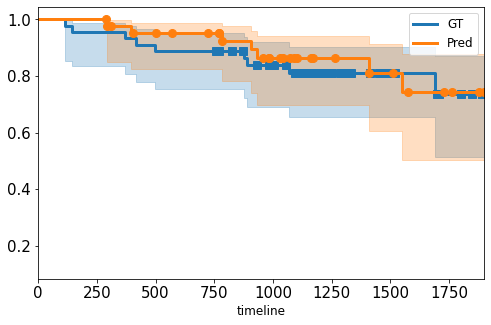

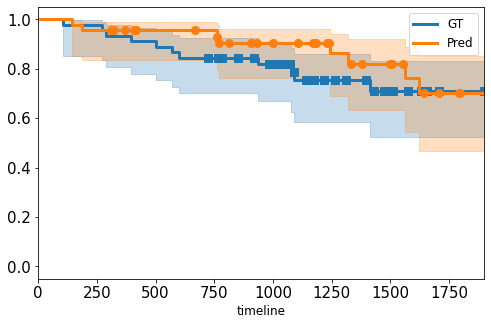

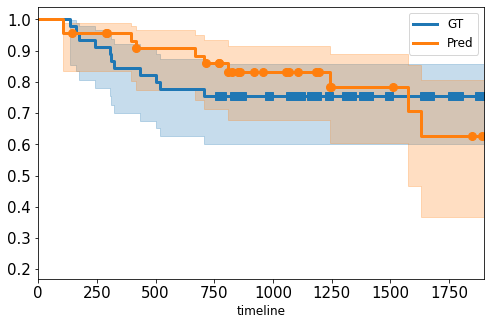

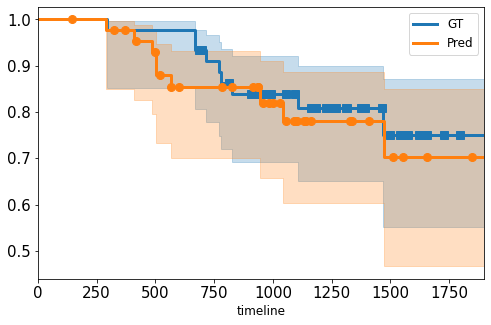

In [17]:
#DecisionTreeRegressor
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
#path='/content/drive/MyDrive/CVSfileHecktor'
#patht=os.path.join(path,'topfeature_fold.csv')
#df = pd.read_csv(patht)
#df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
# #sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# useful_features = [c for c in df.columns if c not in ("participant_id", "target", "kfold")]
# #object_cols = [col for col in useful_features if 'cat' in col]
# #df_test = df_test[useful_features]
# xgb='ggg'
#df = pd.read_csv(patht)
df=df_train
useful_features = [c for c in df.columns if c not in ("PatientID", "target","Progression", "kfold")]
final_predictions = []
final_true = []
y_eventf=[]
for fold in range(4):
  xtrain =  df[df.kfold != fold].reset_index(drop=True)
  xvalid = df[df.kfold == fold].reset_index(drop=True)
  ytrain = xtrain.target
  yvalid = xvalid.target
  y_event=xvalid.Progression
  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]
  min_max_scaler = preprocessing.MinMaxScaler()
  xtrain= min_max_scaler.fit_transform(xtrain)
  xvalid= min_max_scaler.transform(xvalid)
  model=DecisionTreeRegressor(max_leaf_nodes=700,random_state=42)
  model.fit(xtrain, ytrain)
  #model.fit(xtrain, ytrain)
  preds_valid = model.predict(xvalid)
  #test_preds = model.predict(xtest)
  final_predictions.append(preds_valid)
  final_true.append(yvalid)
  y_eventf.append(y_event)
  print(fold, mean_squared_error(yvalid, preds_valid, squared=False))

# predicted survival days for each fold
pred=final_predictions[0]
pred1=final_predictions[1]
pred2=final_predictions[2]
pred3=final_predictions[3]
# true survival days for each fold
true=(final_true)[0]
true1=(final_true)[1]
true2=(final_true)[2]
true3=(final_true)[3]
# event occured for each fold
event=np.array(y_eventf)[0]
event1=np.array(y_eventf)[1]
event2=np.array(y_eventf)[2]
event3=np.array(y_eventf)[3]
## compute c index for each fold
from lifelines.utils import concordance_index
print(f'Concordance index_XGB_fold1: {concordance_index(true, pred,event)}')
print(f'Concordance index_XGB_fold2: {concordance_index(true1, pred1,event1)}')
print(f'Concordance index_XGB_fold3: {concordance_index(true2, pred2,event2)}')
print(f'Concordance index_XGB_fold4: {concordance_index(true3, pred3,event3)}')

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true, event, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred, event, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true1, event1, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred1, event1, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true2, event2, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred2, event2, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true3, event3, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred3, event3, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

0 596.9431953042099
1 627.5880902648028
2 646.3212269916561
3 559.5126339552625
Concordance index_XGB_fold1: 0.6466876971608833
Concordance index_XGB_fold2: 0.612565445026178
Concordance index_XGB_fold3: 0.6806526806526807
Concordance index_XGB_fold4: 0.47468354430379744


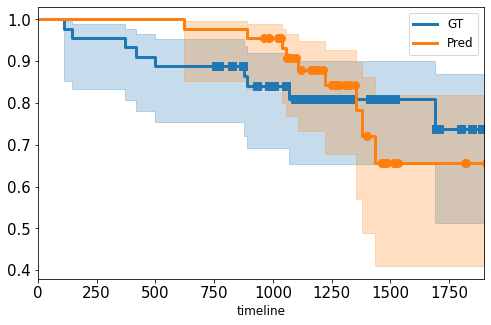

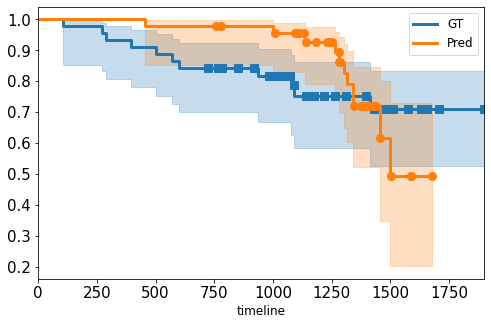

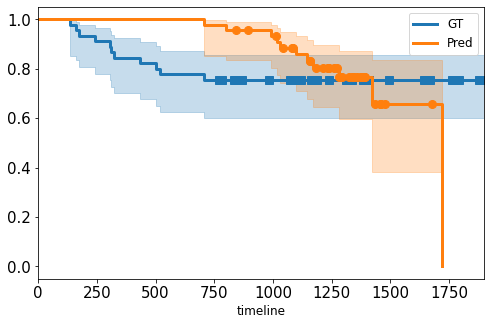

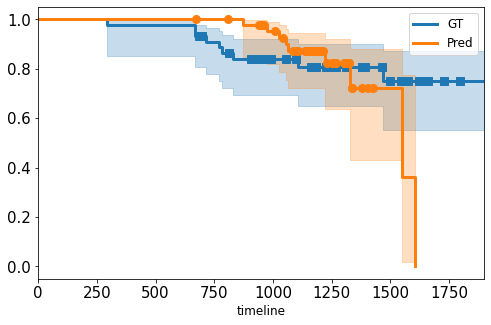

In [18]:
#ExtraTreesRegressor
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
#path='/content/drive/MyDrive/CVSfileHecktor'
#patht=os.path.join(path,'topfeature_fold.csv')
#df = pd.read_csv(patht)
#df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
# #sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# useful_features = [c for c in df.columns if c not in ("participant_id", "target", "kfold")]
# #object_cols = [col for col in useful_features if 'cat' in col]
# #df_test = df_test[useful_features]
# xgb='ggg'
#df = pd.read_csv(patht)
df=df_train
useful_features = [c for c in df.columns if c not in ("PatientID", "target","Progression", "kfold")]
final_predictions = []
final_true = []
y_eventf=[]
for fold in range(4):
  xtrain =  df[df.kfold != fold].reset_index(drop=True)
  xvalid = df[df.kfold == fold].reset_index(drop=True)
  ytrain = xtrain.target
  yvalid = xvalid.target
  y_event=xvalid.Progression
  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]
  min_max_scaler = preprocessing.MinMaxScaler()
  xtrain= min_max_scaler.fit_transform(xtrain)
  xvalid= min_max_scaler.transform(xvalid)
  model=ExtraTreesRegressor(n_estimators=100, random_state=42)
  model.fit(xtrain, ytrain)
  #model.fit(xtrain, ytrain)
  preds_valid = model.predict(xvalid)
  #test_preds = model.predict(xtest)
  final_predictions.append(preds_valid)
  final_true.append(yvalid)
  y_eventf.append(y_event)
  print(fold, mean_squared_error(yvalid, preds_valid, squared=False))

# predicted survival days for each fold
pred=final_predictions[0]
pred1=final_predictions[1]
pred2=final_predictions[2]
pred3=final_predictions[3]
# true survival days for each fold
true=(final_true)[0]
true1=(final_true)[1]
true2=(final_true)[2]
true3=(final_true)[3]
# event occured for each fold
event=np.array(y_eventf)[0]
event1=np.array(y_eventf)[1]
event2=np.array(y_eventf)[2]
event3=np.array(y_eventf)[3]
## compute c index for each fold
from lifelines.utils import concordance_index
print(f'Concordance index_XGB_fold1: {concordance_index(true, pred,event)}')
print(f'Concordance index_XGB_fold2: {concordance_index(true1, pred1,event1)}')
print(f'Concordance index_XGB_fold3: {concordance_index(true2, pred2,event2)}')
print(f'Concordance index_XGB_fold4: {concordance_index(true3, pred3,event3)}')

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true, event, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred, event, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true1, event1, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred1, event1, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true2, event2, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred2, event2, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true3, event3, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred3, event3, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

0 566.2278277080862
1 609.4608863091812
2 648.492440400228
3 492.8484283371523
Concordance index_XGB_fold1: 0.8138801261829653
Concordance index_XGB_fold2: 0.5340314136125655
Concordance index_XGB_fold3: 0.8065268065268065
Concordance index_XGB_fold4: 0.6012658227848101


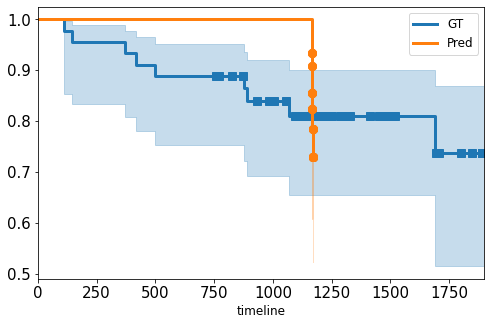

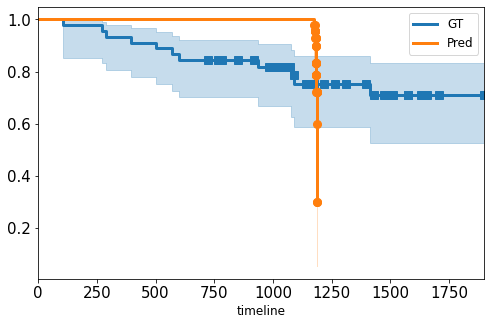

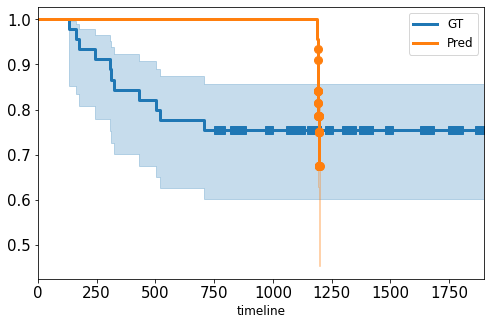

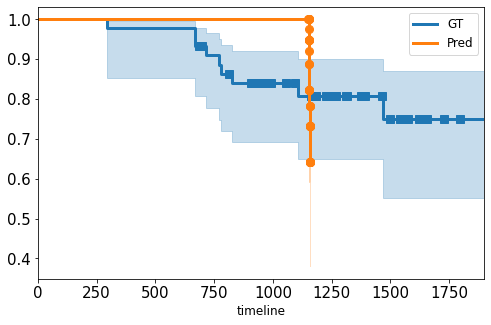

In [19]:
#BaggingRegressor
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
#path='/content/drive/MyDrive/CVSfileHecktor'
#patht=os.path.join(path,'topfeature_fold.csv')
#df = pd.read_csv(patht)
#df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
# #sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# useful_features = [c for c in df.columns if c not in ("participant_id", "target", "kfold")]
# #object_cols = [col for col in useful_features if 'cat' in col]
# #df_test = df_test[useful_features]
# xgb='ggg'
#df = pd.read_csv(patht)
df=df_train
useful_features = [c for c in df.columns if c not in ("PatientID", "target","Progression", "kfold")]
final_predictions = []
final_true = []
y_eventf=[]
for fold in range(4):
  xtrain =  df[df.kfold != fold].reset_index(drop=True)
  xvalid = df[df.kfold == fold].reset_index(drop=True)
  ytrain = xtrain.target
  yvalid = xvalid.target
  y_event=xvalid.Progression
  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]
  min_max_scaler = preprocessing.MinMaxScaler()
  xtrain= min_max_scaler.fit_transform(xtrain)
  xvalid= min_max_scaler.transform(xvalid)
  model=BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0)
  model.fit(xtrain, ytrain)
  #model.fit(xtrain, ytrain)
  preds_valid = model.predict(xvalid)
  #test_preds = model.predict(xtest)
  final_predictions.append(preds_valid)
  final_true.append(yvalid)
  y_eventf.append(y_event)
  print(fold, mean_squared_error(yvalid, preds_valid, squared=False))

# predicted survival days for each fold
pred=final_predictions[0]
pred1=final_predictions[1]
pred2=final_predictions[2]
pred3=final_predictions[3]
# true survival days for each fold
true=(final_true)[0]
true1=(final_true)[1]
true2=(final_true)[2]
true3=(final_true)[3]
# event occured for each fold
event=np.array(y_eventf)[0]
event1=np.array(y_eventf)[1]
event2=np.array(y_eventf)[2]
event3=np.array(y_eventf)[3]
## compute c index for each fold
from lifelines.utils import concordance_index
print(f'Concordance index_XGB_fold1: {concordance_index(true, pred,event)}')
print(f'Concordance index_XGB_fold2: {concordance_index(true1, pred1,event1)}')
print(f'Concordance index_XGB_fold3: {concordance_index(true2, pred2,event2)}')
print(f'Concordance index_XGB_fold4: {concordance_index(true3, pred3,event3)}')

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true, event, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred, event, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true1, event1, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred1, event1, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true2, event2, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred2, event2, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true3, event3, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred3, event3, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

0 665.1707344734884
1 866.1267166721814
2 894.2618476834523
3 590.3413671578317
Concordance index_XGB_fold1: 0.5236593059936908
Concordance index_XGB_fold2: 0.34554973821989526
Concordance index_XGB_fold3: 0.4557109557109557
Concordance index_XGB_fold4: 0.4825949367088608


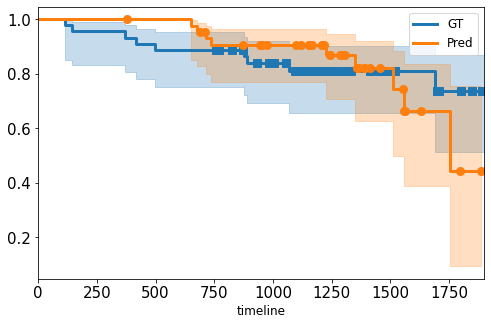

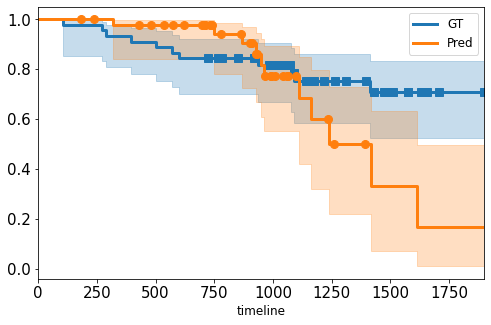

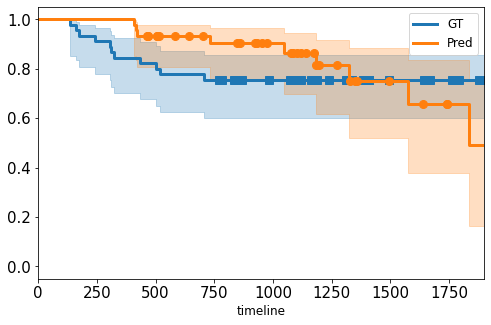

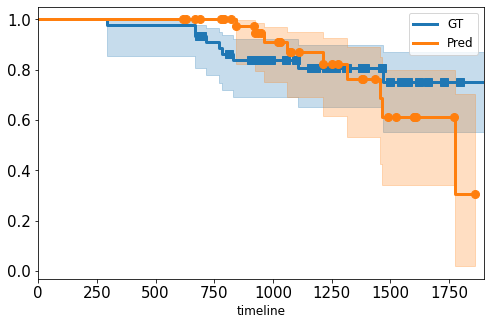

In [20]:
#stackRegressor
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
#path='/content/drive/MyDrive/CVSfileHecktor'
#patht=os.path.join(path,'topfeature_fold.csv')
#df = pd.read_csv(patht)
#df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
# #sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# useful_features = [c for c in df.columns if c not in ("participant_id", "target", "kfold")]
# #object_cols = [col for col in useful_features if 'cat' in col]
# #df_test = df_test[useful_features]
# xgb='ggg'
#df = pd.read_csv(patht)
df=df_train
useful_features = [c for c in df.columns if c not in ("PatientID", "target","Progression", "kfold")]
final_predictions = []
final_true = []
y_eventf=[]
for fold in range(4):
  xtrain =  df[df.kfold != fold].reset_index(drop=True)
  xvalid = df[df.kfold == fold].reset_index(drop=True)
  ytrain = xtrain.target
  yvalid = xvalid.target
  y_event=xvalid.Progression
  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]
  min_max_scaler = preprocessing.MinMaxScaler()
  xtrain= min_max_scaler.fit_transform(xtrain)
  xvalid= min_max_scaler.transform(xvalid)
  #model=BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0)
  estimators = [('lr', RidgeCV()),('svr', LinearSVR(random_state=42))]
  model= StackingRegressor(estimators=estimators,
                           final_estimator=RandomForestRegressor(n_estimators=10,random_state=42)
                           )
  model.fit(xtrain, ytrain)
  #model.fit(xtrain, ytrain)
  preds_valid = model.predict(xvalid)
  #test_preds = model.predict(xtest)
  final_predictions.append(preds_valid)
  final_true.append(yvalid)
  y_eventf.append(y_event)
  print(fold, mean_squared_error(yvalid, preds_valid, squared=False))

# predicted survival days for each fold
pred=final_predictions[0]
pred1=final_predictions[1]
pred2=final_predictions[2]
pred3=final_predictions[3]
# true survival days for each fold
true=(final_true)[0]
true1=(final_true)[1]
true2=(final_true)[2]
true3=(final_true)[3]
# event occured for each fold
event=np.array(y_eventf)[0]
event1=np.array(y_eventf)[1]
event2=np.array(y_eventf)[2]
event3=np.array(y_eventf)[3]
## compute c index for each fold
from lifelines.utils import concordance_index
print(f'Concordance index_XGB_fold1: {concordance_index(true, pred,event)}')
print(f'Concordance index_XGB_fold2: {concordance_index(true1, pred1,event1)}')
print(f'Concordance index_XGB_fold3: {concordance_index(true2, pred2,event2)}')
print(f'Concordance index_XGB_fold4: {concordance_index(true3, pred3,event3)}')

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true, event, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred, event, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true1, event1, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred1, event1, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true2, event2, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred2, event2, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true3, event3, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred3, event3, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

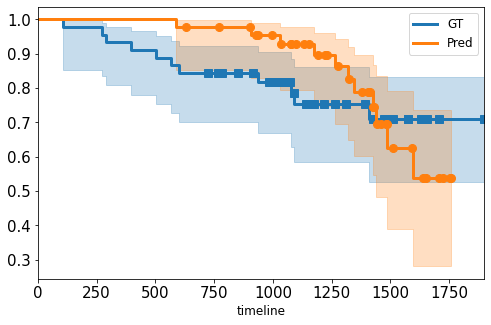

In [29]:
from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true1, event1, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred1, event1, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

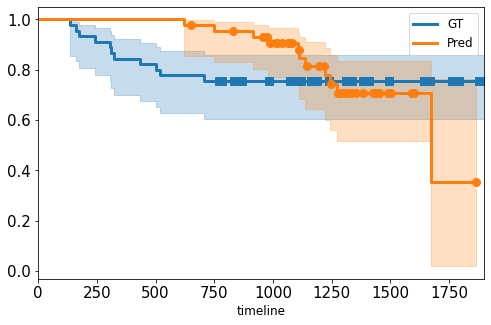

In [30]:
from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true2, event2, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred2, event2, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

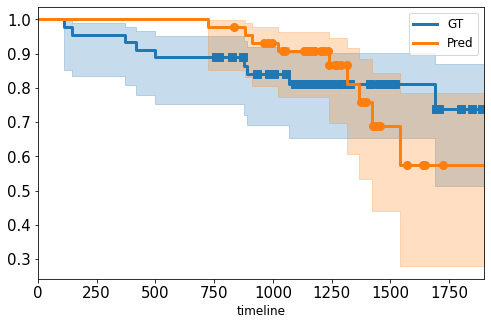

In [31]:
from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true, event, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred, event, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

0 582.6476150973568
1 734.8753859599337
2 670.9872606093877
3 548.3225611470924
Concordance index_XGB_fold1: 0.6182965299684543
Concordance index_XGB_fold2: 0.4607329842931937
Concordance index_XGB_fold3: 0.6177156177156177
Concordance index_XGB_fold4: 0.49683544303797467


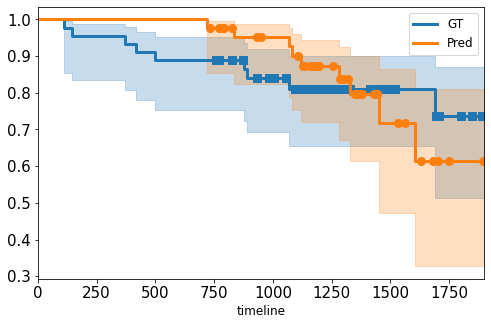

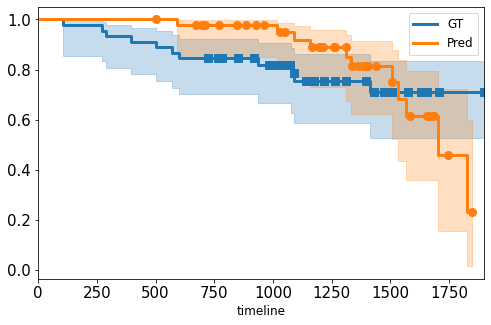

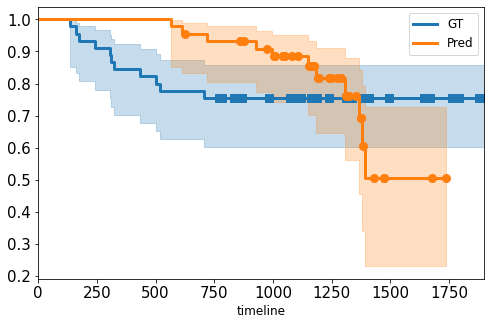

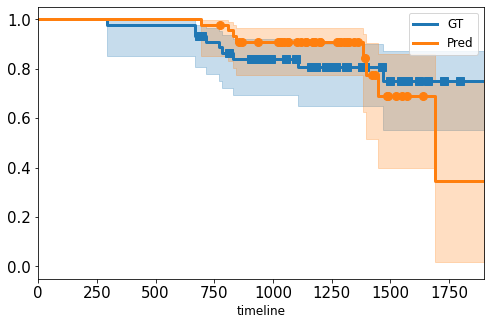

In [21]:
#HistGradientBoostingRegressor()
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
#path='/content/drive/MyDrive/CVSfileHecktor'
#patht=os.path.join(path,'topfeature_fold.csv')
#df = pd.read_csv(patht)
#df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
# #sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# useful_features = [c for c in df.columns if c not in ("participant_id", "target", "kfold")]
# #object_cols = [col for col in useful_features if 'cat' in col]
# #df_test = df_test[useful_features]
# xgb='ggg'
#df = pd.read_csv(patht)
df=df_train
useful_features = [c for c in df.columns if c not in ("PatientID", "target","Progression", "kfold")]
final_predictions = []
final_true = []
y_eventf=[]
for fold in range(4):
  xtrain =  df[df.kfold != fold].reset_index(drop=True)
  xvalid = df[df.kfold == fold].reset_index(drop=True)
  ytrain = xtrain.target
  yvalid = xvalid.target
  y_event=xvalid.Progression
  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]
  min_max_scaler = preprocessing.MinMaxScaler()
  xtrain= min_max_scaler.fit_transform(xtrain)
  xvalid= min_max_scaler.transform(xvalid)
  #model=BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0)
  model= HistGradientBoostingRegressor()
  model.fit(xtrain, ytrain)
  #model.fit(xtrain, ytrain)
  preds_valid = model.predict(xvalid)
  #test_preds = model.predict(xtest)
  final_predictions.append(preds_valid)
  final_true.append(yvalid)
  y_eventf.append(y_event)
  print(fold, mean_squared_error(yvalid, preds_valid, squared=False))

# predicted survival days for each fold
pred=final_predictions[0]
pred1=final_predictions[1]
pred2=final_predictions[2]
pred3=final_predictions[3]
# true survival days for each fold
true=(final_true)[0]
true1=(final_true)[1]
true2=(final_true)[2]
true3=(final_true)[3]
# event occured for each fold
event=np.array(y_eventf)[0]
event1=np.array(y_eventf)[1]
event2=np.array(y_eventf)[2]
event3=np.array(y_eventf)[3]
## compute c index for each fold
from lifelines.utils import concordance_index
print(f'Concordance index_XGB_fold1: {concordance_index(true, pred,event)}')
print(f'Concordance index_XGB_fold2: {concordance_index(true1, pred1,event1)}')
print(f'Concordance index_XGB_fold3: {concordance_index(true2, pred2,event2)}')
print(f'Concordance index_XGB_fold4: {concordance_index(true3, pred3,event3)}')

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true, event, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred, event, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true1, event1, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred1, event1, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true2, event2, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred2, event2, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true3, event3, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred3, event3, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

[09:20:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0 588.7743984607779
[09:20:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 628.0187474523136
[09:20:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2 669.2097375378426
[09:20:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3 598.9965488865187
Concordance index_XGB_fold1: 0.6088328075709779
Concordance index_XGB_fold2: 0.5759162303664922
Concordance index_XGB_fold3: 0.6480186480186481
Concordance index_XGB_fold4: 0.5537974683544303


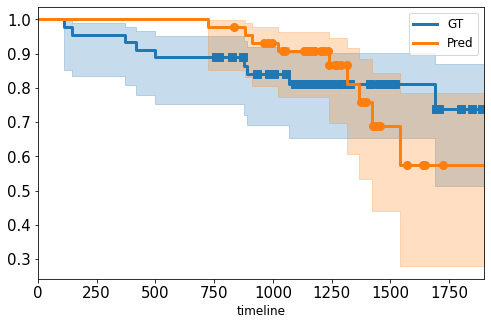

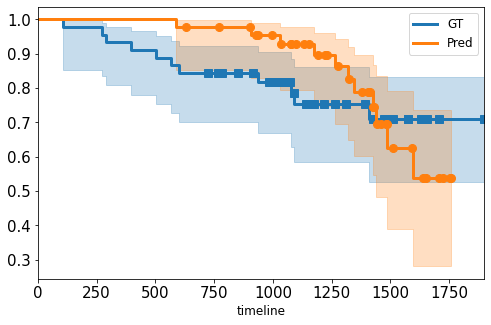

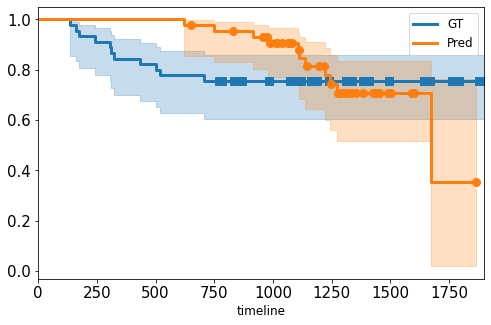

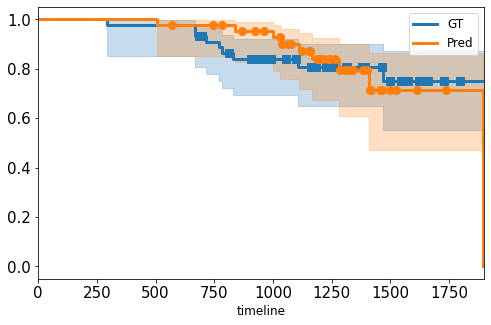

In [27]:
#HistGradientBoostingRegressor()
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
#path='/content/drive/MyDrive/CVSfileHecktor'
#patht=os.path.join(path,'topfeature_fold.csv')
#df = pd.read_csv(patht)
#df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
# #sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# useful_features = [c for c in df.columns if c not in ("participant_id", "target", "kfold")]
# #object_cols = [col for col in useful_features if 'cat' in col]
# #df_test = df_test[useful_features]
# xgb='ggg'
#df = pd.read_csv(patht)
df=df_train
useful_features = [c for c in df.columns if c not in ("PatientID", "target","Progression", "kfold")]
final_predictions = []
final_true = []
y_eventf=[]
for fold in range(4):
  xtrain =  df[df.kfold != fold].reset_index(drop=True)
  xvalid = df[df.kfold == fold].reset_index(drop=True)
  ytrain = xtrain.target
  yvalid = xvalid.target
  y_event=xvalid.Progression
  xtrain = xtrain[useful_features]
  xvalid = xvalid[useful_features]
  min_max_scaler = preprocessing.MinMaxScaler()
  xtrain= min_max_scaler.fit_transform(xtrain)
  xvalid= min_max_scaler.transform(xvalid)
  #model=BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0)
  params = {'learning_rate': 0.07853392035787837, 
            'reg_lambda': 1.7549293092194938e-05, 
            'reg_alpha': 14.68267919457715, 
            'subsample': 0.8031450486786944, 
            'colsample_bytree': 0.170759104940733, 
            'max_depth': 3}
    
  model = XGBRegressor(random_state=0, #tree_method='gpu_hist',#gpu_id=0,
                       #predictor="gpu_predictor",
                      n_estimators=5000,**params)
  model.fit(xtrain, ytrain)
  #model.fit(xtrain, ytrain)
  preds_valid = model.predict(xvalid)
  #test_preds = model.predict(xtest)
  final_predictions.append(preds_valid)
  final_true.append(yvalid)
  y_eventf.append(y_event)
  print(fold, mean_squared_error(yvalid, preds_valid, squared=False))

# predicted survival days for each fold
pred=final_predictions[0]
pred1=final_predictions[1]
pred2=final_predictions[2]
pred3=final_predictions[3]
# true survival days for each fold
true=(final_true)[0]
true1=(final_true)[1]
true2=(final_true)[2]
true3=(final_true)[3]
# event occured for each fold
event=np.array(y_eventf)[0]
event1=np.array(y_eventf)[1]
event2=np.array(y_eventf)[2]
event3=np.array(y_eventf)[3]
## compute c index for each fold
from lifelines.utils import concordance_index
print(f'Concordance index_XGB_fold1: {concordance_index(true, pred,event)}')
print(f'Concordance index_XGB_fold2: {concordance_index(true1, pred1,event1)}')
print(f'Concordance index_XGB_fold3: {concordance_index(true2, pred2,event2)}')
print(f'Concordance index_XGB_fold4: {concordance_index(true3, pred3,event3)}')

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true, event, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred, event, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true1, event1, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred1, event1, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true2, event2, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred2, event2, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true3, event3, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
#ax.set_xlabel('Years', size = 10)

#fontsize = 20
#fontweight = 'bold'
#fontproperties = {'family':'sans-serif','sans-serif':['Helvetica'],'weight' : fontweight, 'size' : fontsize}
#ax.set_xticklabels(ax.get_xticks(), fontproperties)
#ax.set_yticklabels(ax.get_yticks(), fontproperties)

kmf.fit(pred3, event3, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

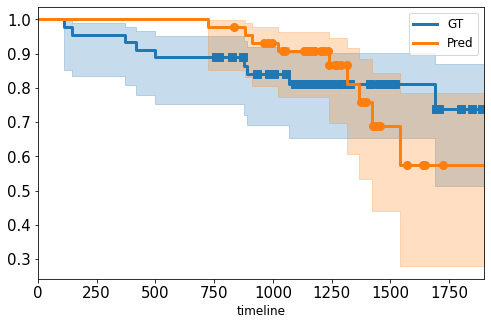

In [28]:
from lifelines import KaplanMeierFitter
import numpy as np
from matplotlib import rc,rcParams
from pylab import *

## create a kmf object
kmf = KaplanMeierFitter() 
f = figure(figsize=(8,5))
## Fit the data into the model

kmf.fit(true, event, label='GT')    ## fit the cohort 1 data
#ax = kmf.plot(linewidth = 3,at_risk_counts=True,show_censors=True, censor_styles={'ms': 6, 'marker': 's'})
ax = kmf.plot(linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 's'})
ax.set_xlim([0.0, 1900])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.legend(loc = 'upper right', fontsize = 20)
kmf.fit(pred, event, label='Pred')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax,linewidth = 3,show_censors=True, censor_styles={'ms': 8, 'marker': 'o'})
ax1.set_xlabel('timeline', size = 12)
ax1.legend(loc = 'upper right', fontsize = 12)

In [24]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
#path='/content/drive/MyDrive/CVSfileHecktor'
#patht='/content/drive/MyDrive/CVSfileHecktor/combined_features.csv'
#df = pd.read_csv(patht)
#df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
# #sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

# useful_features = [c for c in df.columns if c not in ("participant_id", "target", "kfold")]
# #object_cols = [col for col in useful_features if 'cat' in col]
# #df_test = df_test[useful_features]
# xgb='ggg'

class model_selection:
    def __init__(self,root,model_selec):
        self.root=root
        self.model_selec=model_selec
        self.df = df_train
        self.useful_features = [c for c in self.df.columns if c not in ("PatientID", "target","Progression", "kfold")]
    def model_selction(self):
        final_predictions = []
        final_true = []
        y_eventf=[]
        for fold in range(4):
            xtrain =  self.df[self.df.kfold != fold].reset_index(drop=True)
            xvalid = self.df[self.df.kfold == fold].reset_index(drop=True)
            #xtest = df_test.copy()

            ytrain = xtrain.target
            yvalid = xvalid.target
            y_event=xvalid.Progression
    
            xtrain = xtrain[self.useful_features]
            xvalid = xvalid[self.useful_features]
            min_max_scaler = preprocessing.MinMaxScaler()
            xtrain= min_max_scaler.fit_transform(xtrain)
            xvalid= min_max_scaler.transform(xvalid)
            if self.model_selec=='XGB':
                model=XGBRegressor(n_estimators=500, learning_rate=0.03, n_jobs=4)
                model.fit(xtrain, ytrain, early_stopping_rounds=5, eval_set=[(xvalid, yvalid)],verbose=False)
                #model.fit(xtrain, ytrain)
                preds_valid = model.predict(xvalid)
    
                #test_preds = model.predict(xtest)
                final_predictions.append(preds_valid)
                final_true.append(yvalid)
                y_eventf.append(y_event)
                print(fold, mean_squared_error(yvalid, preds_valid, squared=False))
        
            elif self.model_selec=='GB':
                model = GradientBoostingRegressor(n_estimators=700,random_state=42)
                model.fit(xtrain, ytrain)
                preds_valid = model.predict(xvalid)
                #test_preds = model.predict(xtest)
                final_predictions.append(preds_valid)
                final_true.append(yvalid)
                y_eventf.append(y_event)
                print(fold, mean_squared_error(yvalid, preds_valid, squared=False))
                
            elif self.model_selec=='RF':
                model = RandomForestRegressor(random_state=42)
                model.fit(xtrain, ytrain)
                preds_valid = model.predict(xvalid)
                #test_preds = model.predict(xtest)
                final_predictions.append(preds_valid)
                final_true.append(yvalid)
                y_eventf.append(y_event)
                print(fold, mean_squared_error(yvalid, preds_valid, squared=False))
            
            
            elif self.model_selec=='DT':
                model = DecisionTreeRegressor(max_leaf_nodes=500, random_state=42)
                model.fit(xtrain, ytrain)
                preds_valid = model.predict(xvalid)
                #test_preds = model.predict(xtest)
                final_predictions.append(preds_valid)
                final_true.append(yvalid)
                y_eventf.append(y_event)
                print(fold, mean_squared_error(yvalid, preds_valid, squared=False))
               
            elif self.model_selec=='ET':
                
                model=ExtraTreesRegressor(n_estimators=100, random_state=42) 
                model.fit(xtrain, ytrain)
                preds_valid = model.predict(xvalid)
                #test_preds = model.predict(xtest)
                final_predictions.append(preds_valid)
                final_true.append(yvalid)
                y_eventf.append(y_event)
                print(fold, mean_squared_error(yvalid, preds_valid, squared=False))
                
            elif self.model_selec=='BR':
                model=BaggingRegressor(base_estimator=SVR(),n_estimators=10, random_state=0)
                model.fit(xtrain, ytrain)
                preds_valid = model.predict(xvalid)
                #test_preds = model.predict(xtest)
                final_predictions.append(preds_valid)
                final_true.append(yvalid)
                y_eventf.append(y_event)
                print(fold, mean_squared_error(yvalid, preds_valid, squared=False))
                
            elif self.model_selec=='SR':
                estimators = [('lr', RidgeCV()),('svr', LinearSVR(random_state=42))]
                model= StackingRegressor(estimators=estimators,
                                         final_estimator=RandomForestRegressor(n_estimators=10,
                                                                               random_state=42)
                                         )
                model.fit(xtrain, ytrain)
                preds_valid = model.predict(xvalid)
                #test_preds = model.predict(xtest)
                final_predictions.append(preds_valid)
                final_true.append(yvalid)
                y_eventf.append(y_event)
                print(fold, mean_squared_error(yvalid, preds_valid, squared=False))
                
            elif self.model_selec=='VR':
                r1 = LinearRegression()
                r2 = RandomForestRegressor(n_estimators=10, random_state=42)
                model= VotingRegressor([('lr', r1), ('rf', r2)])
                model.fit(xtrain, ytrain)
                preds_valid = model.predict(xvalid)
                #test_preds = model.predict(xtest)
                final_predictions.append(preds_valid)
                final_true.append(yvalid)
                y_eventf.append(y_event)
                print(fold, mean_squared_error(yvalid, preds_valid, squared=False))
                
            elif self.model_selec=='HGB':
                model= HistGradientBoostingRegressor()
                model.fit(xtrain, ytrain)
                preds_valid = model.predict(xvalid)
                #test_preds = model.predict(xtest)
                final_predictions.append(preds_valid)
                final_true.append(yvalid)
                y_eventf.append(y_event)
                print(fold, mean_squared_error(yvalid, preds_valid, squared=False))
                
            elif self.model_selec=='XGbOPTM':
                params = {'learning_rate': 0.07853392035787837, 'reg_lambda': 1.7549293092194938e-05, 'reg_alpha': 14.68267919457715, 'subsample': 0.8031450486786944, 'colsample_bytree': 0.170759104940733, 'max_depth': 3}
    
                model = XGBRegressor(random_state=0, #tree_method='gpu_hist',
                                     #gpu_id=0,
                                     #predictor="gpu_predictor",
                                     n_estimators=5000,
                                     **params
                                     )
                model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=1000)
                preds_valid = model.predict(xvalid)
                #test_preds = model.predict(xtest)
                final_predictions.append(preds_valid)
                final_true.append(yvalid)
                y_eventf.append(y_event)
                #rmse = mean_squared_error(yvalid, preds_valid, squared=False)
                #print(fold, rmse)
                print(fold, mean_squared_error(yvalid, preds_valid, squared=False))
            
            
        preds = np.mean(np.column_stack(final_predictions), axis=1)
        true = np.mean(np.column_stack(final_true), axis=1)
        y_eventn=np.mean(np.column_stack(y_eventf), axis=1)
        return preds,true,y_eventn
    
  
model= HistGradientBoostingRegressor()    
  
selction=['XGB','GB','RF','DT','ET','BR','SR','VR','HGB','XGbOPTM']
dfdic={'pred':[],'GT':[],'event':[],}
for i in selction:
    #model_selec='XGB'
    model1=model_selection(pathf,i) 
    preds,true,y_eventn=model1.model_selction() 
    dfdic['pred'].append(preds)
    dfdic['GT'].append(true)
    dfdic['event'].append(y_eventn)


dff=pd.DataFrame(dfdic['GT']).T
dff.rename(columns={0:'target'}, inplace=True)
gt=dff['target']
dff1=pd.DataFrame(dfdic['event']).T
#print(dff1)
#dff.rename(columns={11:'event'}, inplace=True)
modelspred=pd.DataFrame(dfdic['pred']).T

modelspred.rename(columns={0:'XGB',
                       1:'GB',
                       2:'RF',
                       3:'DT',
                       4:'ET',
                       5:'BT',
                       6:'SR',
                       7:'VR',
                       8:'HGB',
                       9:'XGbOPTM',}, inplace=True)

Results=pd.concat([modelspred,gt],axis=1)

[09:18:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0 565.3451771977603
[09:18:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 664.1553695643273
[09:18:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2 654.5107780503536
[09:18:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3 570.4416534712459
0 590.8003635886897
1 653.7433111150675
2 706.5115498644556
3 613.105403558407
0 569.5234583091766
1 652.127656158414
2 632.6220191499293
3 556.7761881203055
0 915.3814019910559
1 846.0932835358311
2 780.8677651604443
3 721.1493449888018
0 596.9431953042099
1 627.5880902648028
2 646.3212269916561
3 559.5126339552625
0 566.2278277080862
1 609.4608863091812
2 648.492440400228
3 492.8484283371523
0 665.170734473

In [25]:
GT=Results['target']
XGB=Results['XGB']
GB=Results['GB']
RF=Results['RF']
DT=Results['DT']
ET=Results['ET']
BT=Results['BT']
SR=Results['SR']
VR=Results['VR']
HGB=Results['HGB']
XGbOPTM=Results['XGbOPTM']
print(f'Concordance index_XGB: {concordance_index(GT,XGB)}')
print(f'Concordance index_GB: {concordance_index(GT,GB)}')
print(f'Concordance index_RF: {concordance_index(GT,RF)}')
print(f'Concordance index_DT: {concordance_index(GT,DT)}')
print(f'Concordance index_ET: {concordance_index(GT,ET)}')
print(f'Concordance index_BT: {concordance_index(GT,BT)}')
print(f'Concordance index_SR: {concordance_index(GT,SR)}')
print(f'Concordance index_VR: {concordance_index(GT,VR)}')
print(f'Concordance index_HGB: {concordance_index(GT,HGB)}')
print(f'Concordance index_XGbOPTM: {concordance_index(GT,XGbOPTM)}')

Concordance index_XGB: 0.5151515151515151
Concordance index_GB: 0.5434343434343434
Concordance index_RF: 0.5323232323232323
Concordance index_DT: 0.501010101010101
Concordance index_ET: 0.5767676767676768
Concordance index_BT: 0.5898989898989899
Concordance index_SR: 0.46464646464646464
Concordance index_VR: 0.5262626262626262
Concordance index_HGB: 0.5686868686868687
Concordance index_XGbOPTM: 0.5808080808080808
